# Housing Regression Maching Learning Project

### Imports (Data and Packages)

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="white")
%matplotlib inline 

In [12]:
housing = pd.read_csv('./data/Ames_Housing_Price_Data.csv', index_col=0)
housing = housing[housing['SaleCondition'] == 'Normal']
real_estate = pd.read_csv('./data/Ames_Real_Estate_data.csv' , index_col = 0)

FileNotFoundError: [Errno 2] No such file or directory: './data/Ames_Housing_Price_Data.csv'

In [ ]:
housing['Neighborhood'].unique()

array(['SWISU', 'Edwards', 'IDOTRR', 'OldTown', 'NWAmes', 'Mitchel',
       'NridgHt', 'NAmes', 'CollgCr', 'SawyerW', 'MeadowV', 'BrDale',
       'Timber', 'Somerst', 'Gilbert', 'BrkSide', 'NoRidge', 'Sawyer',
       'Crawfor', 'Greens', 'ClearCr', 'GrnHill', 'StoneBr', 'Veenker',
       'NPkVill', 'Blmngtn', 'Blueste', 'Landmrk'], dtype=object)

### Beginning to Clean Data and Handle Null Values

In [ ]:
## Checking for null values
columns_with_nulls = {}
for column in housing.columns:
    if(housing[column].isnull().sum() > 0):
        columns_with_nulls[column] = housing[column].isnull().sum()

print(columns_with_nulls)


{'LotFrontage': 451, 'Alley': 2260, 'MasVnrType': 11, 'MasVnrArea': 11, 'BsmtQual': 67, 'BsmtCond': 67, 'BsmtExposure': 69, 'BsmtFinType1': 67, 'BsmtFinType2': 68, 'Electrical': 1, 'BsmtFullBath': 1, 'BsmtHalfBath': 1, 'FireplaceQu': 1164, 'GarageType': 116, 'GarageYrBlt': 117, 'GarageFinish': 117, 'GarageQual': 117, 'GarageCond': 117, 'PoolQC': 2405, 'Fence': 1912, 'MiscFeature': 2318}


In [ ]:

## Replace all null values based on context

## LotFrontage -- replace with mean of the column 
housing['LotFrontage'].fillna(value = housing['LotFrontage'].mean(), inplace = True)

## Replace Nulls where NA just means that the house does not have the feature 

## Basement metrics
housing['BsmtQual'].fillna(value = 'No_Basement', inplace=True)
housing['BsmtCond'].fillna(value = 'No_Basement', inplace=True)
housing['BsmtExposure'].fillna(value = 'No_Basement', inplace=True)
housing['BsmtFinType1'].fillna(value = 'No_Basement', inplace=True)
housing['BsmtFinType2'].fillna(value = 'No_Basement', inplace=True)

## Garage Type 
housing['GarageType'].fillna(value = 'No_Garage', inplace=True)
housing['GarageYrBlt'].fillna(value = 'No_Garage', inplace=True)
housing['GarageFinish'].fillna(value = 'No_Garage', inplace=True)
housing['GarageQual'].fillna(value = 'No_Garage', inplace=True)
housing['GarageCond'].fillna(value = 'No_Garage', inplace=True)

## Replace other nulls where null just means the feature is not there 
housing['FireplaceQu'].fillna(value = 'No_Fireplace', inplace=True)
housing['PoolQC'].fillna(value = 'No_Pool', inplace=True)
housing['Fence'].fillna(value = 'No_Fence', inplace=True)
housing['MiscFeature'].fillna(value = 'No_Misc', inplace=True)
housing['Alley'].fillna(value = 'No_alley', inplace=True)

##----------------------------------------------------------------##

##Replacing nulls with 0s

housing['BsmtFinSF1'].fillna(value = 0, inplace=True)
housing['BsmtFinSF2'].fillna(value = 0, inplace=True)
housing['BsmtUnfSF'].fillna(value = 0, inplace=True)
housing['MasVnrType'].fillna(value = 0, inplace=True)
housing['TotalBsmtSF'].fillna(value = 0, inplace=True)
housing['MasVnrArea'].fillna(value = 0, inplace=True)
housing['BsmtFullBath'].fillna(value = 0, inplace=True)
housing['BsmtHalfBath'].fillna(value = 0, inplace=True)
housing['GarageCars'].fillna(value = 0, inplace=True)
housing['GarageArea'].fillna(value = 0, inplace=True)


## At this point, only one null value remains in the "Electric Column". We will just remove that one row 
housing.dropna(axis = 0, inplace = True)

### EDA

<AxesSubplot:>

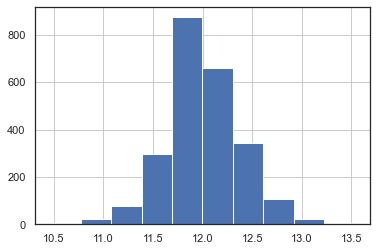

In [ ]:
## First looking at Sale Price to see the features
np.log(housing['SalePrice']).hist()

## Histogram looks skewed right - is this going to be a problem? Maybe try a boxcox transformation or log? 

In [ ]:
## See correlations related to sale price and to eyeball which features might matter the most 
corrs = housing.corr()
highly_correlated = corrs[np.abs(corrs['SalePrice']) >= .6]
medium_correlated = corrs[np.abs(corrs['SalePrice']).between(.4,.6)] 
low_correlated = corrs[(np.abs(corrs['SalePrice']) < .4)] 

## Print out column headers that are going to have high and medium correlations to sales price 
print('Highly correlated variables are: ')
print(highly_correlated['SalePrice'])
print('-'*150)
print('Medium correlated variables are: ')
print(medium_correlated['SalePrice'])

Highly correlated variables are: 
GrLivArea      0.736040
SalePrice      1.000000
OverallQual    0.787266
TotalBsmtSF    0.642555
1stFlrSF       0.634755
GarageCars     0.632217
GarageArea     0.621855
Name: SalePrice, dtype: float64
------------------------------------------------------------------------------------------------------------------------------------------------------
Medium correlated variables are: 
YearBuilt       0.533163
YearRemodAdd    0.501543
MasVnrArea      0.486528
BsmtFinSF1      0.454164
FullBath        0.548532
TotRmsAbvGrd    0.496571
Fireplaces      0.493448
Name: SalePrice, dtype: float64


In [ ]:
## Checking for null values to see if all have been handled. Dictionary should return empty
columns_with_nulls = {}
for column in housing.columns:
    if(housing[column].isnull().sum() > 0):
        columns_with_nulls[column] = housing[column].isnull().sum()

print(columns_with_nulls)


NameError: name 'housing' is not defined

### Start dummifying variables and look at multicollinearity

In [3]:
## Identify Categorical Variables and create a list of them (With PID included so we can use as key later on)
category_list = list(housing.select_dtypes('object').columns)
category_list.append('PID')

## Use the list above to create a dataframe with just the categorical variables and PID
category_variables = housing[housing.columns.intersection(category_list)]

## Dummify the categorical variables
category = pd.get_dummies(data = category_variables, prefix_sep = '_' , drop_first=True)

## Remove the original categorical values from the dataframe and merge the dummified and original values into a new dataframe called final
housing.drop(columns = housing.select_dtypes('object').columns, axis =1, inplace=True)
final = pd.concat(housing, category, axis=1)


NameError: name 'housing' is not defined

In [124]:
#Messing around with regression just to see

from sklearn.linear_model import LinearRegression

target = housing['SalePrice']
housing.drop(['SalePrice'] , axis =1, inplace = True)
for_model = housing[['GrLivArea', 'OverallQual', 'TotalBsmtSF' , '1stFlrSF' , 'GarageCars', 'GarageArea']]


lm = LinearRegression()
lm.fit(for_model, np.log(target))
lm.score(for_model, np.log(target))


0.8251755521965729